<a href="https://colab.research.google.com/github/Evgeny-Artemov/Deep_Learning/blob/main/DL_Courses/Word2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задание 5.1 - Word2Vec

В этом задании мы натренируем свои word vectors на очень небольшом датасете.
Мы будем использовать самую простую версию word2vec, без negative sampling и других оптимизаций.

Перед запуском нужно запустить скрипт `download_data.sh` чтобы скачать данные.

Датасет и модель очень небольшие, поэтому это задание можно выполнить и без GPU.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset

from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt

# We'll use Principal Component Analysis (PCA) to visualize word vectors,
# so make sure you install dependencies from requirements.txt!
from sklearn.decomposition import PCA 

%matplotlib inline

In [ ]:
!wget http://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip

--2023-04-30 07:23:40--  http://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip [following]
--2023-04-30 07:23:40--  https://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6372817 (6.1M) [application/zip]
Saving to: ‘stanfordSentimentTreebank.zip’

stanfordSentimentTr 100%[===================>]   6.08M  1.70MB/s    in 4.4s    

2023-04-30 07:23:45 (1.39 MB/s) - ‘stanfordSentimentTreebank.zip’ saved [6372817/6372817]



In [ ]:
!unzip stanfordSentimentTreebank.zip 

Archive:  stanfordSentimentTreebank.zip
   creating: stanfordSentimentTreebank/
  inflating: stanfordSentimentTreebank/datasetSentences.txt  
   creating: __MACOSX/
   creating: __MACOSX/stanfordSentimentTreebank/
  inflating: __MACOSX/stanfordSentimentTreebank/._datasetSentences.txt  
  inflating: stanfordSentimentTreebank/datasetSplit.txt  
  inflating: __MACOSX/stanfordSentimentTreebank/._datasetSplit.txt  
  inflating: stanfordSentimentTreebank/dictionary.txt  
  inflating: __MACOSX/stanfordSentimentTreebank/._dictionary.txt  
  inflating: stanfordSentimentTreebank/original_rt_snippets.txt  
  inflating: __MACOSX/stanfordSentimentTreebank/._original_rt_snippets.txt  
  inflating: stanfordSentimentTreebank/README.txt  
  inflating: __MACOSX/stanfordSentimentTreebank/._README.txt  
  inflating: stanfordSentimentTreebank/sentiment_labels.txt  
  inflating: __MACOSX/stanfordSentimentTreebank/._sentiment_labels.txt  
  inflating: stanfordSentimentTreebank/SOStr.txt  
  inflating: stanfo

In [ ]:
!ls stanfordSentimentTreebank


datasetSentences.txt  dictionary.txt		README.txt	      SOStr.txt
datasetSplit.txt      original_rt_snippets.txt	sentiment_labels.txt  STree.txt


In [ ]:
!rm stanfordSentimentTreebank.zip

In [ ]:
import os
import numpy as np

class StanfordTreeBank:
    '''
    Wrapper for accessing Stanford Tree Bank Dataset
    https://nlp.stanford.edu/sentiment/treebank.html
    
    Parses dataset, gives each token and index and provides lookups
    from string token to index and back
    
    Allows to generate random context with sampling strategy described in
    word2vec paper:
    https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf
    '''
    def __init__(self):
        self.index_by_token = {}
        self.token_by_index = [] 

        self.sentences = [] 

        self.token_freq = {} 
        
        self.token_reject_by_index = None

    def load_dataset(self, folder):
        filename = os.path.join(folder, "datasetSentences.txt")

        with open(filename, "r", encoding="latin1") as f:
            l = f.readline() # skip the first line
            
            for l in f:
                splitted_line = l.strip().split()
                words = [w.lower() for w in splitted_line[1:]] # First one is a number
                    
                self.sentences.append(words)
                for word in words:
                    if word in self.token_freq:
                        self.token_freq[word] +=1 
                    else:
                        index = len(self.token_by_index)
                        self.token_freq[word] = 1
                        self.index_by_token[word] = index
                        self.token_by_index.append(word)
        self.compute_token_prob()
                        
    def compute_token_prob(self):
        words_count = np.array([self.token_freq[token] for token in self.token_by_index])
        words_freq = words_count / np.sum(words_count)
        
        # Following sampling strategy from word2vec paper:
        # https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf
        self.token_reject_by_index = 1- np.sqrt(1e-5/words_freq)
    
    def check_reject(self, word):
        return np.random.rand() > self.token_reject_by_index[self.index_by_token[word]]
        
    def get_random_context(self, context_length=5):
        """
        Returns tuple of center word and list of context words
        """
        sentence_sampled = []
        while len(sentence_sampled) <= 2:
            sentence_index = np.random.randint(len(self.sentences)) 
            sentence = self.sentences[sentence_index]
            sentence_sampled = [word for word in sentence if self.check_reject(word)]
    
        center_word_index = np.random.randint(len(sentence_sampled))
        
        words_before = sentence_sampled[max(center_word_index - context_length//2,0):center_word_index]
        words_after = sentence_sampled[center_word_index+1: center_word_index+1+context_length//2]
        
        return sentence_sampled[center_word_index], words_before+words_after
    
    def num_tokens(self):
        return len(self.token_by_index)
        
data = StanfordTreeBank()
data.load_dataset("./stanfordSentimentTreebank/")

print("Num tokens:", data.num_tokens())
for i in range(5):
    center_word, other_words = data.get_random_context(10)
    print(center_word, other_words)

Num tokens: 19538
foremost ['blue', 'phenomenal', 'water-born', 'hennings']
too ['too', 'ensuing', 'blatant', 'resolutions', 'convenient']
ong ['well-told', 'recent', 'immigrant']
styles ['schumacher', 'anyone', 'at', 'bringing', 'hopkins\\/rock', 'onscreen', 'personas']
gianni ['working', 'a', 'co-written', 'romoli', '...', 'ozpetek', 'pitfalls', "'d"]


# Имплеменируем PyTorch-style Dataset для Word2Vec

Этот Dataset должен сгенерировать много случайных контекстов и превратить их в сэмплы для тренировки.

Напоминаем, что word2vec модель получает на вход One-hot вектор слова и тренирует простую сеть для предсказания на его основе соседних слов.
Из набора слово-контекст создается N сэмплов (где N - количество слов в контексте):

Например:

Слово: `orders` и контекст: `['love', 'nicest', 'to', '50-year']` создадут 4 сэмпла:
- input: `orders`, target: `love`
- input: `orders`, target: `nicest`
- input: `orders`, target: `to`
- input: `orders`, target: `50-year`

Все слова на входе и на выходе закодированы через one-hot encoding, с размером вектора равным количеству токенов.

In [ ]:
class Word2VecPlain(Dataset):
    '''
    PyTorch Dataset for plain Word2Vec.
    Accepts StanfordTreebank as data and is able to generate dataset based on
    a number of random contexts
    '''
    def __init__(self, data, num_sample=30000):
        '''
        Initializes Word2VecPlain, but doesn't generate the samples yet
        (for that, use generate_dataset)
        Arguments:
        data - StanfordTreebank instace
        num_contexts - number of random contexts to use when generating a dataset
        '''
        
        # TODO: Implement what you need for other methods!
        self.num_tokens = len(data.token_by_index)
        self.data = data
        self.num_sample = num_sample
        self.DataSet = [] 
    
    def generate_dataset(self):
        '''
        Generates dataset samples from random contexts
        Note: there will be more samples than contexts because every context
        can generate more than one sample
        '''
        
        # TODO: Implement generating the dataset
        # You should sample num_contexts contexts from the data and turn them into samples
        # Note you will have several samples from one context
        
        for i in range(self.num_sample):
          central_word, contex = self.data.get_random_context(3)

          input_vector = torch.zeros(self.num_tokens)
          index = self.data.index_by_token[central_word]
          input_vector[index] = 1

          for j in contex:
            sample = []

            output_index = self.data.index_by_token[j]

            sample.append(input_vector)
            sample.append(output_index)
            
            self.DataSet.append(sample)

    def __len__(self):
        '''
        Returns total number of samples
        '''
        # TODO: Return the number of samples
        return len(self.DataSet)
    
    def __getitem__(self, index):
        '''
        Returns i-th sample
        
        Return values:
        input_vector - torch.Tensor with one-hot representation of the input vector
        output_index - index of the target word (not torch.Tensor!)
        '''
        if torch.is_tensor(index):
          index.tolist()

        return self.DataSet[index][0], self.DataSet[index][1]
        # TODO: Generate tuple of 2 return arguments for i-th sample   


dataset = Word2VecPlain(data, 10)
dataset.generate_dataset()
input_vector, target = dataset[3]
print("Sample - input: %s, target: %s" % (input_vector, int(target))) # target should be able to convert to int
assert isinstance(input_vector, torch.Tensor)
assert torch.sum(input_vector) == 1.0
assert input_vector.shape[0] == data.num_tokens()

Sample - input: tensor([0., 0., 0.,  ..., 0., 0., 0.]), target: 7914


In [ ]:
class Word2VecPlain(Dataset):
    '''
    PyTorch Dataset for plain Word2Vec.
    Accepts StanfordTreebank as data and is able to generate dataset based on
    a number of random contexts
    '''
    def __init__(self, data, num_contexts=30000):
        '''
        Initializes Word2VecPlain, but doesn't generate the samples yet
        (for that, use generate_dataset)
        Arguments:
        data - StanfordTreebank instace
        num_contexts - number of random contexts to use when generating a dataset
        '''
        # TODO: Implement what you need for other methods!
        self.data = data
        self.num_tokens = data.num_tokens()
        self.index_by_token = data.index_by_token
        self.num_contexts = num_contexts
        self.generated_samples = []
    
    def generate_dataset(self):
        '''
        Generates dataset samples from random contexts
        Note: there will be more samples than contexts because every context
        can generate more than one sample
        '''
        # TODO: Implement generating the dataset
        # You should sample num_contexts contexts from the data and turn them into samples
        # Note you will have several samples from one context        
        for i in range(self.num_contexts):
            center_word, other_words = self.data.get_random_context(3)
            center_word_index = self.index_by_token[center_word]
            input_vector = torch.zeros(self.num_tokens)
            input_vector[center_word_index] = 1
            
            for output_word in (other_words):
                sample = []
                output_word_index = self.index_by_token[output_word]
                sample.append(input_vector)
                sample.append(output_word_index)
                
                self.generated_samples.append(sample)
            
        
    def __len__(self):
        '''
        Returns total number of samples
        '''
        # TODO: Return the number of samples
        return len(self.generated_samples)
    
    def __getitem__(self, index):
        '''
        Returns i-th sample
        
        Return values:
        input_vector - torch.Tensor with one-hot representation of the input vector
        output_index - index of the target word (not torch.Tensor!)
        '''
        # TODO: Generate tuple of 2 return arguments for i-th sample
        sample = self.generated_samples[index]
        input_vector, output_index = sample[0], sample[1]
        
        return input_vector, output_index

# Создаем модель и тренируем ее

In [ ]:
# Create the usual PyTorch structures
dataset = Word2VecPlain(data, 30000)
dataset.generate_dataset()

# We'll be training very small word vectors!
wordvec_dim = 10

# We can use a standard sequential model for this
nn_model = nn.Sequential(
            nn.Linear(dataset.num_tokens, wordvec_dim, bias=False),
            nn.Linear(wordvec_dim, dataset.num_tokens, bias=False), 
         )
nn_model.type(torch.FloatTensor)

Sequential(
  (0): Linear(in_features=19538, out_features=10, bias=False)
  (1): Linear(in_features=10, out_features=19538, bias=False)
)

In [ ]:
def extract_word_vectors(nn_model):
    '''
    Extracts word vectors from the model
    
    Returns:
    input_vectors: torch.Tensor with dimensions (num_tokens, num_dimensions)
    output_vectors: torch.Tensor with dimensions (num_tokens, num_dimensions)
    '''
    # TODO: Implement extracting word vectors from param weights
    # return tuple of input vectors and output vectos 
    # Hint: you can access weights as Tensors through nn.Linear class attributes

    untrained_input_vectors = nn_model[0].weight.T
    untrained_output_vectors = nn_model[1].weight

    return untrained_input_vectors,  untrained_output_vectors
    
untrained_input_vectors, untrained_output_vectors = extract_word_vectors(nn_model)
assert untrained_input_vectors.shape == (data.num_tokens(), wordvec_dim)
assert untrained_output_vectors.shape == (data.num_tokens(), wordvec_dim)

In [ ]:
def train_model(model, dataset, train_loader, optimizer, scheduler, num_epochs):
    '''
    Trains plain word2vec using cross-entropy loss and regenerating dataset every epoch
    
    Returns:
    loss_history, train_history
    '''
    device = torch.device('cuda:0')

    loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
    model = model.to(device)

    loss_history = []
    train_history = []
    for epoch in range(num_epochs):

        model.train() # Enter train mode 
        dataset.generate_dataset() # Regenerate dataset every epoch
        

        acum_loss = 0
        predict_true = 0
        totalsample = 0

        for iter, (x, y) in enumerate(train_loader):
          x_gpu = x.to(device)
          y_gpu = y.to(device)

          predict = model(x_gpu)
          losses = loss(predict, y_gpu)
          
          optimizer.zero_grad()
          losses.backward()
          optimizer.step()

          indices = torch.argmax(predict, 1)

          acum_loss += losses.item()
          predict_true += torch.sum(y_gpu == indices)
          totalsample += len(indices)

        ave_loss = acum_loss / (iter + 1)
        train_accuracy = (predict_true / totalsample).item()

       if scheduler:
         scheduler.step() 
        loss_history.append(ave_loss)
        train_history.append(train_accuracy)
        # TODO Implement training for this model
        # Note we don't have any validation set here because our purpose is the word vectors,
        # not the predictive performance of the model
        #
        # And don't forget to step the learing rate scheduler!  
        print("Epoch %i, Average loss: %f, Train accuracy: %f" % (epoch, ave_loss, train_accuracy))
        
    return loss_history, train_history

# Ну и наконец тренировка!

Добейтесь значения ошибки меньше **8.0**.

In [ ]:
# Finally, let's train the model!

# TODO: We use placeholder values for hyperparameters - you will need to find better values!
best_loss = float('inf')
best_model = None
best_optim = None
end_to_loss, end_to_train = [], []

for i in range(5):
  lr = np.random.uniform(1e-2, 5e-4)
  step_size = np.random.choice([2,4,6,8,10])
  batch_size = int(np.random.choice([16,20,24,28]))
  gamma = np.random.uniform(0.5, 0.9)

  wordvec_dim = 15

# We can use a standard sequential model for this
  nn_model = nn.Sequential(
            nn.Linear(dataset.num_tokens, wordvec_dim, bias=False),
            nn.Linear(wordvec_dim, dataset.num_tokens, bias=False), 
         )
  nn_model.type(torch.FloatTensor)

  optimizer = optim.Adam(nn_model.parameters(), lr=lr, weight_decay = lr * 0.001)
  scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
  train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)

  loss_history, train_history = train_model(nn_model, dataset, train_loader, optimizer, scheduler, 50)

  if loss_history[-1] < best_loss:
    end_to_loss = loss_history
    end_to_train = train_history

    best_model = nn_model
    best_optim = optimizer

    best_loss = loss_history[-1]


Epoch 0, Average loss: 9.880045, Train accuracy: 0.000818
Epoch 1, Average loss: 9.873083, Train accuracy: 0.134304
Epoch 2, Average loss: 9.863538, Train accuracy: 0.189752
Epoch 3, Average loss: 9.849380, Train accuracy: 0.217563
Epoch 4, Average loss: 9.829695, Train accuracy: 0.235938
Epoch 5, Average loss: 9.801393, Train accuracy: 0.253282
Epoch 6, Average loss: 9.760170, Train accuracy: 0.259711
Epoch 7, Average loss: 9.695096, Train accuracy: 0.258841
Epoch 8, Average loss: 9.595100, Train accuracy: 0.236783
Epoch 9, Average loss: 9.459666, Train accuracy: 0.197204
Epoch 10, Average loss: 9.285374, Train accuracy: 0.155523
Epoch 11, Average loss: 9.075971, Train accuracy: 0.114388
Epoch 12, Average loss: 8.850537, Train accuracy: 0.082328
Epoch 13, Average loss: 8.587171, Train accuracy: 0.055478
Epoch 14, Average loss: 8.334176, Train accuracy: 0.040390
Epoch 15, Average loss: 8.097403, Train accuracy: 0.034483
Epoch 16, Average loss: 7.888744, Train accuracy: 0.027967
Epoch 1

In [ ]:
dataset = Word2VecPlain(data, 30000)
dataset.generate_dataset()

wordvec_dim = 15

nn_model = nn.Sequential(
          nn.Linear(dataset.num_tokens, wordvec_dim, bias=False),
          nn.Linear(wordvec_dim, dataset.num_tokens, bias=False), 
        )

nn_model.type(torch.FloatTensor)

optimizer = best_optim
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)
train_loader = torch.utils.data.DataLoader(dataset, batch_size = 28)

loss_history, train_history = train_model(nn_model, dataset, train_loader, optimizer, scheduler, 15)

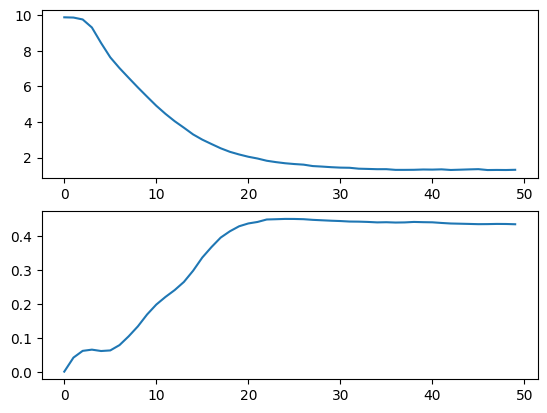

In [ ]:
# Visualize training graphs
plt.subplot(211)
plt.plot(end_to_loss)
plt.subplot(212)
plt.plot(end_to_train)

# Визуализируем вектора для разного вида слов до и после тренировки

В случае успешной тренировки вы должны увидеть как вектора слов разных типов (например, знаков препинания, предлогов и остальных) разделяются семантически.

Студенты - в качестве выполненного задания присылайте notebook с диаграммами!

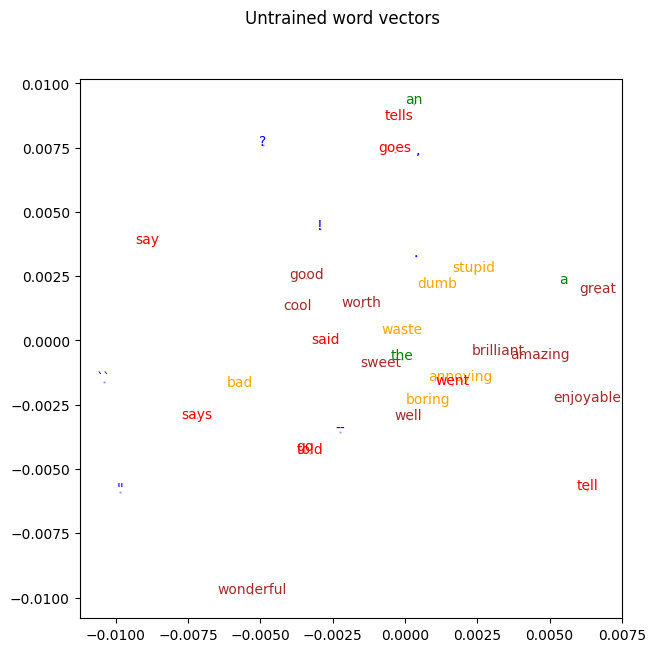

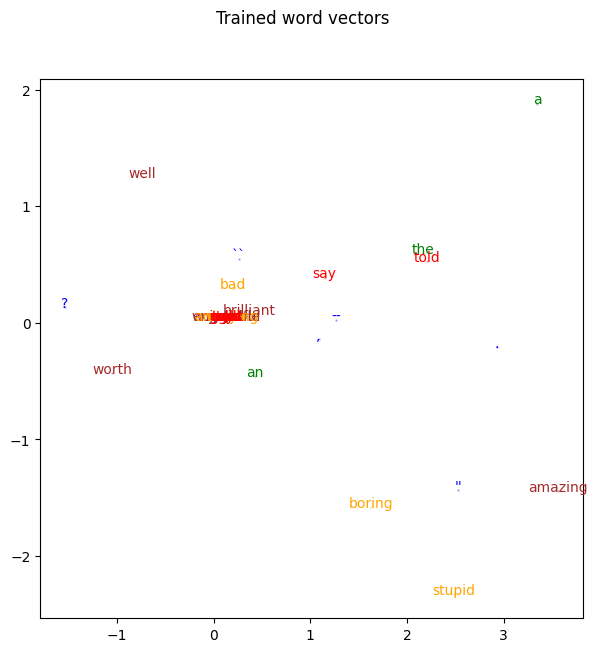

In [ ]:
trained_input_vectors, trained_output_vectors = extract_word_vectors(best_model)
assert trained_input_vectors.shape == (data.num_tokens(), wordvec_dim)
assert trained_output_vectors.shape == (data.num_tokens(), wordvec_dim)

def visualize_vectors(input_vectors, output_vectors, title=''):
    full_vectors = torch.cat((input_vectors, output_vectors), 0)
    full_vectors = full_vectors.cpu().detach().numpy()
    wordvec_embedding = PCA(n_components=2).fit_transform(full_vectors)

    # Helpful words form CS244D example
    # http://cs224d.stanford.edu/assignment1/index.html
    visualize_words = {'green': ["the", "a", "an"], 
                      'blue': [",", ".", "?", "!", "``", "''", "--"], 
                      'brown': ["good", "great", "cool", "brilliant", "wonderful", 
                              "well", "amazing", "worth", "sweet", "enjoyable"],
                      'orange': ["boring", "bad", "waste", "dumb", "annoying", "stupid"],
                      'red': ['tell', 'told', 'said', 'say', 'says', 'tells', 'goes', 'go', 'went']
                     }

    plt.figure(figsize=(7,7))
    plt.suptitle(title)
    for color, words in visualize_words.items():
        points = np.array([wordvec_embedding[data.index_by_token[w]] for w in words])
        for i, word in enumerate(words):
            plt.text(points[i, 0], points[i, 1], word, color=color,horizontalalignment='center')
        plt.scatter(points[:, 0], points[:, 1], c=color, alpha=0.3, s=0.5)

visualize_vectors(untrained_input_vectors, untrained_output_vectors, "Untrained word vectors")
visualize_vectors(trained_input_vectors, trained_output_vectors, "Trained word vectors")